---

## [미니프로젝트] 서울시 공유자전거 '따릉이'의 수요 예측

### 여러분은 서울시 정책 연구원으로써 서울시 공유자전거인 '따릉이'의 수요와 날씨간 연관성을 분석하라는 미션을 부여받았습니다.

#### <font color="blue"> 데이터 분석의 주 목적은 가치있는 정보를 찾아내는것!! </font>

### ▣ 우리가 풀어야 하는 문제는 무엇인가요?

 - 기상상황이 따릉이 수요에 주는 영향을 분석해봅시다.

---

## ▣ 데이터 소개
[기본 데이터]
* 학습데이터 : traindata.csv

## ▣ 데이터셋의 변수 소개
* date : 날짜
* hour : 시간
* temperature : 온도
* precipitation : 강우 여부, 비가 오지 않았으면 0, 비가 오면 1
* windspeed : 풍속(평균)
* humidity : 습도
* visibility : 시정(視程), 시계(視界)(특정 기상 상태에 따른 가시성을 의미)
* ozone : 오존 수치
* PM10 : 미세먼지 수치(머리카락 굵기의 1/5에서 1/7 크기의 미세먼지)
* PM2.5 : 초미세먼지 수치(머리카락 굵기의 1/20에서 1/30 크기의 미세먼지)
* count : 시간에 따른 따릉이 대여 수

---

### [과제1] 환경 설정
#### <span style="color: green"> 1) 라이브러리 불러오기 </span>

In [1]:
#EDA에 사용할 라이브러리를 import 하세요
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as spst
from statsmodels.graphics.mosaicplot import mosaic
import statsmodels.api as sm

In [2]:
plt.rc('font', family='nanum')
sns.set(font="NanumGothicCoding",#"NanumGothicCoding", 
        rc={"axes.unicode_minus":False}, # 마이너스 부호 깨짐 현상 해결
        style='darkgrid')     

In [3]:
import warnings
warnings.filterwarnings(action='ignore')

#### <span style="color: green"> 2) 활용할 데이터 불러오기 </span>

In [4]:
#이번 프로젝트에서 분석할 데이터를 불러오세요
data = pd.read_csv('traindata.csv')
data.head()

,date,hour,PM10,PM2.5,ozone,temperature,precipitation,windspeed,humidity,visibility,count
0,2021-04-01,1,42.0,21.0,0.002,13.1,0,1.4,49,2000,46
1,2021-04-01,2,41.0,21.0,0.003,12.4,0,2.1,53,2000,40
2,2021-04-01,3,30.0,13.0,0.023,13.1,0,3.4,43,2000,31
3,2021-04-01,4,27.0,12.0,0.028,13.0,0,3.1,44,2000,12
4,2021-04-01,5,29.0,14.0,0.008,13.0,0,2.9,44,2000,30


In [5]:
data['temp'] = data['ozone'].shift()
data

,date,hour,PM10,PM2.5,ozone,temperature,precipitation,windspeed,humidity,visibility,count,temp
0,2021-04-01,1,42.0,21.0,0.002,13.1,0,1.4,49,2000,46,NaN
1,2021-04-01,2,41.0,21.0,0.003,12.4,0,2.1,53,2000,40,0.002
2,2021-04-01,3,30.0,13.0,0.023,13.1,0,3.4,43,2000,31,0.003
3,2021-04-01,4,27.0,12.0,0.028,13.0,0,3.1,44,2000,12,0.023
4,2021-04-01,5,29.0,14.0,0.008,13.0,0,2.9,44,2000,30,0.028
...,...,...,...,...,...,...,...,...,...,...,...,...
5822,2021-11-29,20,74.0,58.0,0.002,9.3,0,0.3,66,1193,273,0.002
5823,2021-11-29,21,65.0,56.0,0.002,8.4,0,2.0,70,1233,228,0.002
5824,2021-11-29,22,51.0,41.0,0.002,8.6,0,1.9,70,1250,215,0.002
5825,2021-11-29,23,43.0,35.0,0.001,8.2,0,2.1,71,1262,125,0.002


In [6]:
data['temp'].describe()

count    5698.000000
mean        0.031816
std         0.018275
min         0.001000
25%         0.019000
50%         0.031000
75%         0.041000
max         0.137000
Name: temp, dtype: float64

In [7]:
feature = 'temp'

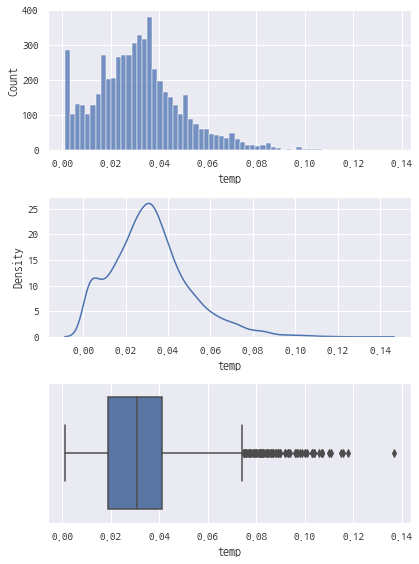

In [9]:
plt.figure(figsize = (6,8))
plt.subplot(3,1,1)
sns.histplot(data[feature], bins = 64)

plt.subplot(3,1,2)
sns.kdeplot(data[feature])

plt.subplot(3,1,3)
sns.boxplot(data[feature])

plt.tight_layout()
plt.show()

### [과제2] 가설설정
#### '가설' 이란 단어를 생각해보면, 우리가 직접 가설을 만들어야 할것 같지만 통계에서 분석기법별 귀무가설/대립가설은 정해져있습니다.
- 귀무가설은 차이가 없다, 연관성이 없다, 효과가 없다.
- 대립가설은 차이가 있다, 연관성이 있다, 효과가 있다. 라고 간단하게 이해하시면 좋습니다.

#### 간단한 예로, 온도와 따릉이 대여량간 가설을 수립 해본다면

    - 귀무가설 : 온도와 따릉이 간에는 연관성이 없다.
    - 대립가설 : 온도와 따릉이 간에는 연관성이 있다.

로 가설이 자연스레 수립 됩니다.



---


#### <span style="color: green"> 'precipitation' 변수를 포함하여, 최소 5개 이상의 Feature와 따릉이 대여량 간 가설을 수립해주세요. </span>

##### Guide : Target은 따릉이 대여량 입니다.

- 가설 1 : 1시간전 강우 여부와 따릉이간에는 연관성이 없다.
    
    ㅇ 대립가설 : 1시간전 강우 여부와 따릉이 대여량 간에는 연관성이 있다.


- 가설 2 : 시간과 따릉이 간에는 연관성이 없다.
    ㅇ 대립가설 : 시간과 따릉이 대여량 간에는 연관성이 있다.
 

- 가설 3 :

- 가설 4 :

- 가설 5 :

- 가설 6 :

### [과제3] 단변량 분석

단변량 분석은 데이터분석의 매우 기초적인 분석기법으로, 독립적인 개별 변수가 가지고있는 특성들을 이해하는 과정입니다.

<span style="color: green"> 개별 변수에 대해 아래 사항들을 분석해보세요. </span>

1. 변수가 내포하고 있는 의미
2. 변수가 수치형인지, 범주형인지
3. 결측치 존재 여부 및 조치 방안
4. 기초 통계량 확인
5. 데이터 분포 확인
6. 위 정보로부터 파악한 내용 정리
7. 추가 분석사항 도출

### Feature1 : hour

1. 변수가 내포하고 있는 의미
- 변수의 의미를 한번 짚고 넘어갑시다. 여러분이 생각하는 이 변수의 의미를 작성해보세요.

In [6]:
feature = 'hour'

초미세먼지 수치(머리카락 굵기의 1/20에서 1/30 크기의 미세먼지)
좋음 : 0~15
보통 : 16~35
나쁨 : 36~75
매우나쁨 : 76~
세계보건기구 기준에 따르면 초미세먼지 수치가 25μg/m³이하여야 보통의 환경이다. 
                                             50μg/m³이상이면 매우 나쁜 환경이다.

2. 변수가 수치형인지 범주형인지


In [ ]:
#변수의 자료형을 확인해보세요.
수치형이다.

In [ ]:
수치형 데이터이다.

3. 변수의 결측치 존재 여부 및 조치방안

In [100]:
#변수의 결측치 존재 여부를 확인하고, 만약 결측치가 존재하면 어떻게 처리할지 고민해보세요. 
data[target].isna().sum()

0

In [5]:
data[feature].isna().sum()

0

4. 변수의 기초 통계량 확인

In [102]:
#변수의 기초 통계량을 확인해보세요
data[target].describe()

count    5827.000000
mean      215.117899
std       185.972900
min         1.000000
25%        53.000000
50%       186.000000
75%       315.000000
max      1746.000000
Name: count, dtype: float64

In [7]:
data[feature].describe()

count    5827.000000
mean       11.506607
std         6.921963
min         0.000000
25%         6.000000
50%        12.000000
75%        18.000000
max        23.000000
Name: hour, dtype: float64

5. 변수의 분포 확인

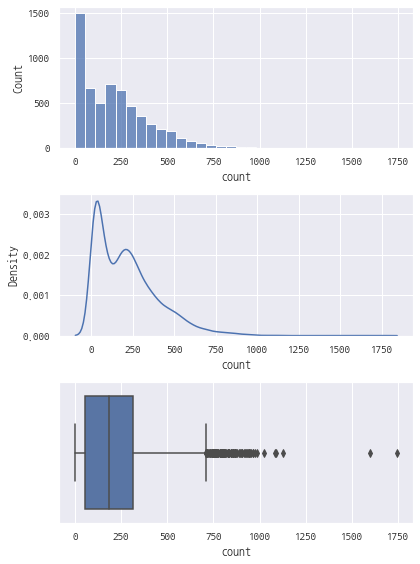

In [107]:
#변수의 분포를 시각화 라이브러리를 활용해 확인해보세요.
plt.figure(figsize = (6,8))
plt.subplot(3,1,1)
sns.histplot(data[target], bins = 32)

plt.subplot(3,1,2)
sns.kdeplot(data[target])

plt.subplot(3,1,3)
sns.boxplot(data[target])

plt.tight_layout()
plt.show()

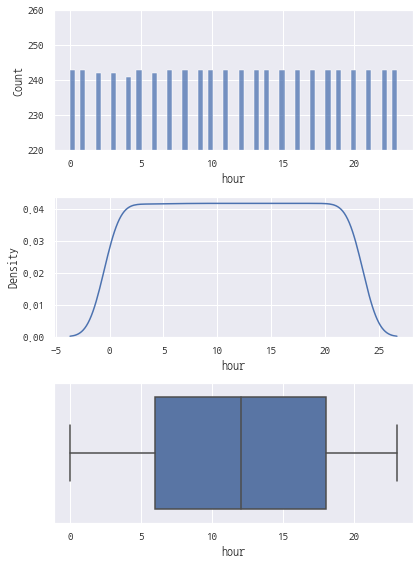

In [14]:
plt.figure(figsize = (6,8))
plt.subplot(3,1,1)
plt.ylim(220, 260)
sns.histplot(data[feature], bins = 64)

plt.subplot(3,1,2)
sns.kdeplot(data[feature])

plt.subplot(3,1,3)
sns.boxplot(data[feature])

plt.tight_layout()
plt.show()

6. 위 정보로 부터 파악한 내용 정리

In [ ]:
#위 정보로부터 파악하신 내용을 정리해보세요.
두가지 그룹으로 나눠지는것 같은데 0인 부분이랑 100이상인 부분으로 나눠지는것같다.

0인부분은 아마 밤이지 않을까 싶다.
밤에는 따릉이를 타기 어려우니깐 데이터적으로 빼는것도 고려해볼만하다.

7. 추가 분석사항 도출

In [ ]:
#추가로 분석을 원하는 부분이 있다면 분석후 정리해보세요.
낮과 밤데이터 구분 분석

### Feature2 : temperature

1. 변수가 내포하고 있는 의미
- 변수의 의미를 한번 짚고 넘어갑시다. 여러분이 생각하는 이 변수의 의미를 작성해보세요.

In [16]:
data.head()

,date,hour,PM10,PM2.5,ozone,temperature,precipitation,windspeed,humidity,visibility,count
0,2021-04-01,1,42.0,21.0,0.002,13.1,0,1.4,49,2000,46
1,2021-04-01,2,41.0,21.0,0.003,12.4,0,2.1,53,2000,40
2,2021-04-01,3,30.0,13.0,0.023,13.1,0,3.4,43,2000,31
3,2021-04-01,4,27.0,12.0,0.028,13.0,0,3.1,44,2000,12
4,2021-04-01,5,29.0,14.0,0.008,13.0,0,2.9,44,2000,30


In [15]:
feature = 'temperature'

In [ ]:
온도로 섭씨 온도를 나타낸다.

2. 변수가 수치형인지 범주형인지


In [ ]:
#변수의 자료형을 확인해보세요.
수치형이다.

3. 변수의 결측치 존재 여부 및 조치방안

In [17]:
#변수의 결측치 존재 여부를 확인하고, 만약 결측치가 존재하면 어떻게 처리할지 고민해보세요. 
data[feature].isna().sum()

0

In [ ]:
x, 결측치가 존재하지 않는다.

4. 변수의 기초 통계량 확인

In [102]:
#변수의 기초 통계량을 확인해보세요
data[target].describe()

count    5827.000000
mean      215.117899
std       185.972900
min         1.000000
25%        53.000000
50%       186.000000
75%       315.000000
max      1746.000000
Name: count, dtype: float64

5. 변수의 분포 확인

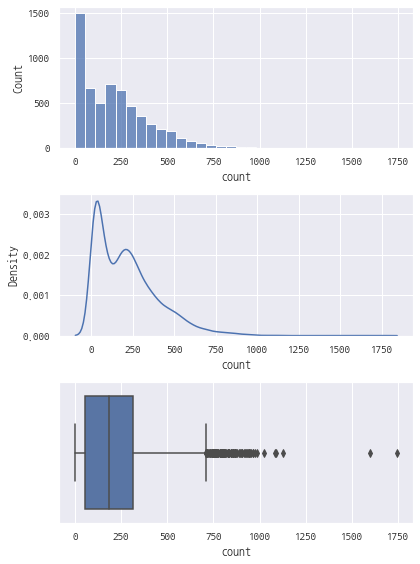

In [107]:
#변수의 분포를 시각화 라이브러리를 활용해 확인해보세요.
plt.figure(figsize = (6,8))
plt.subplot(3,1,1)
sns.histplot(data[target], bins = 32)

plt.subplot(3,1,2)
sns.kdeplot(data[target])

plt.subplot(3,1,3)
sns.boxplot(data[target])

plt.tight_layout()
plt.show()

6. 위 정보로 부터 파악한 내용 정리

In [ ]:
#위 정보로부터 파악하신 내용을 정리해보세요.
두가지 그룹으로 나눠지는것 같은데 0인 부분이랑 100이상인 부분으로 나눠지는것같다.

0인부분은 아마 밤이지 않을까 싶다.
밤에는 따릉이를 타기 어려우니깐 데이터적으로 빼는것도 고려해볼만하다.

In [ ]:
#추가로 분석을 원하는 부분이 있다면 분석후 정리해보세요.
낮과 밤데이터 구분 분석

### Feature3 : precipitation

1. 변수가 내포하고 있는 의미
- 변수의 의미를 한번 짚고 넘어갑시다. 여러분이 생각하는 이 변수의 의미를 작성해보세요.

In [23]:
feature = 'precipitation'

초미세먼지 수치(머리카락 굵기의 1/20에서 1/30 크기의 미세먼지)
좋음 : 0~15
보통 : 16~35
나쁨 : 36~75
매우나쁨 : 76~
세계보건기구 기준에 따르면 초미세먼지 수치가 25μg/m³이하여야 보통의 환경이다. 
                                             50μg/m³이상이면 매우 나쁜 환경이다.

2. 변수가 수치형인지 범주형인지


In [ ]:
#변수의 자료형을 확인해보세요.
수치형이다.

3. 변수의 결측치 존재 여부 및 조치방안

In [100]:
#변수의 결측치 존재 여부를 확인하고, 만약 결측치가 존재하면 어떻게 처리할지 고민해보세요. 
data[target].isna().sum()

0

4. 변수의 기초 통계량 확인

In [102]:
#변수의 기초 통계량을 확인해보세요
data[target].describe()

count    5827.000000
mean      215.117899
std       185.972900
min         1.000000
25%        53.000000
50%       186.000000
75%       315.000000
max      1746.000000
Name: count, dtype: float64

5. 변수의 분포 확인

In [30]:
temp = data[feature].value_counts()
temp

0    5387
1     440
Name: precipitation, dtype: int64

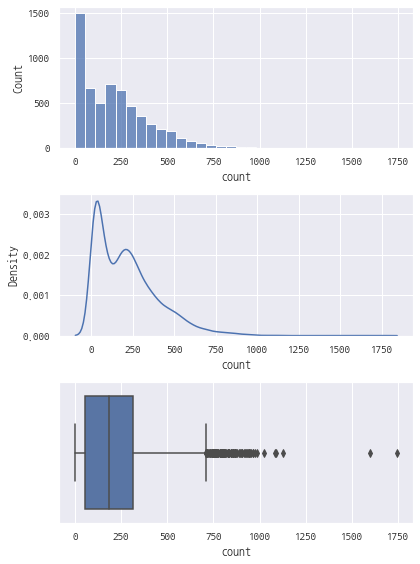

In [107]:
#변수의 분포를 시각화 라이브러리를 활용해 확인해보세요.
plt.figure(figsize = (6,8))
plt.subplot(3,1,1)
sns.histplot(data[target], bins = 32)

plt.subplot(3,1,2)
sns.kdeplot(data[target])

plt.subplot(3,1,3)
sns.boxplot(data[target])

plt.tight_layout()
plt.show()

6. 위 정보로 부터 파악한 내용 정리

In [ ]:
#위 정보로부터 파악하신 내용을 정리해보세요.
두가지 그룹으로 나눠지는것 같은데 0인 부분이랑 100이상인 부분으로 나눠지는것같다.

0인부분은 아마 밤이지 않을까 싶다.
밤에는 따릉이를 타기 어려우니깐 데이터적으로 빼는것도 고려해볼만하다.

7. 추가 분석사항 도출

In [ ]:
#추가로 분석을 원하는 부분이 있다면 분석후 정리해보세요.
낮과 밤데이터 구분 분석

### Feature4 : windspeed

In [128]:
feature = 'windspeed'

1. 변수가 내포하고 있는 의미
- 변수의 의미를 한번 짚고 넘어갑시다. 여러분이 생각하는 이 변수의 의미를 작성해보세요.

In [120]:
data[feature]

0       1.4
1       2.1
2       3.4
3       3.1
4       2.9
       ... 
5822    0.3
5823    2.0
5824    1.9
5825    2.1
5826    2.3
Name: windspeed, Length: 5827, dtype: float64

In [121]:
단위 : m/s
    
풍속의 단위

0.0-0.2 연기가 똑바로 올라가고 수면이 잔잔하다

0.3-1.5 바람에 나뭇잎이 약간 움직임, 연풍

1.6-3.3 바람이 얼굴에 느껴지고 바람개비가 약하게 돈다

3.4-5.4 나뭇가지가 쉴새없이 흔들리고 깃발이 가볍게 흔들린다

5.5-7.9 먼지가 일고 종이조각이 날린다

8.0-10.7 작은 나무가 흔들리고 바다에서 잔물결이 일어난다

10.8-13.8 큰 나뭇가지와 전선이 흔들리고 우산을 들고있기 힘들다

13.9-17.1 큰 나무 전체가 흔들리고 바람을 거실러걷기 힘들다

17.2-20.7 잔가지가 꺽이고 걷기 힘들다

20.8-24.4 굴뚝이 넘어지고 기와가 벗겨진다

24.5-28.4 건물이 무너지고 나무가 쓰러진다

28.5-32.6 건물이 크게 부서지고 차가넘어가며 나무가 뿌리채 뽑힌다

32.7 이상 육지는 초토화되고 바다에선 해일이 들이닥친다

SyntaxError: invalid syntax (Temp/ipykernel_4408/2620488683.py, line 3)

2. 변수가 수치형인지 범주형인지


In [122]:
#변수의 자료형을 확인해보세요.
수치형 데이터

SyntaxError: invalid syntax (Temp/ipykernel_4408/3191878136.py, line 2)

3. 변수의 결측치 존재 여부 및 조치방안

In [129]:
#변수의 결측치 존재 여부를 확인하고, 만약 결측치가 존재하면 어떻게 처리할지 고민해보세요. 
data[feature].isna().sum()

0

In [130]:
x 결측치는 존재하지않는다.

SyntaxError: invalid syntax (Temp/ipykernel_4408/664178336.py, line 1)

4. 변수의 기초 통계량 확인

In [131]:
#변수의 기초 통계량을 확인해보세요
data[feature].describe()

count    5827.000000
mean        2.237601
std         1.054516
min         0.000000
25%         1.500000
50%         2.200000
75%         2.800000
max         8.300000
Name: windspeed, dtype: float64

5. 변수의 분포 확인

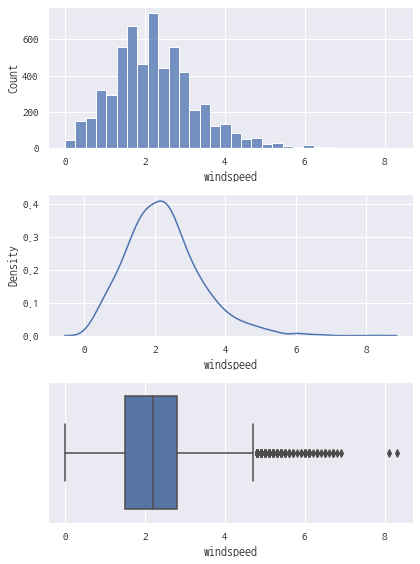

In [132]:
#변수의 분포를 시각화 라이브러리를 활용해 확인해보세요.
plt.figure(figsize = (6,8))
plt.subplot(3,1,1)
sns.histplot(data[feature], bins = 32)

plt.subplot(3,1,2)
sns.kdeplot(data[feature])

plt.subplot(3,1,3)
sns.boxplot(data[feature])

plt.tight_layout()
plt.show()

In [133]:
data[feature].value_counts().head(20)

2.3    255
2.2    246
2.1    242
1.9    239
1.7    235
2.0    227
2.5    225
2.6    223
1.8    222
2.4    217
1.6    215
1.4    205
1.5    191
2.7    170
2.9    169
1.3    164
2.8    164
1.2    152
1.1    139
3.1    127
Name: windspeed, dtype: int64

6. 위 정보로 부터 파악한 내용 정리

In [ ]:
#위 정보로부터 파악하신 내용을 정리해보세요.
count    5827.000000
mean        2.237601
std         1.054516
min         0.000000
25%         1.500000
50%         2.200000
75%         2.800000
max         8.300000
Name: windspeed, dtype: float64

평균값 2.3 중간값 2.2
min 0.0, max 8.3

7. 추가 분석사항 도출

In [ ]:
#추가로 분석을 원하는 부분이 있다면 분석후 정리해보세요.


### Feature5 : humidity

In [90]:
feature = 'humidity'

In [79]:
data[feature]

0       49
1       53
2       43
3       44
4       44
        ..
5822    66
5823    70
5824    70
5825    71
5826    71
Name: humidity, Length: 5827, dtype: int64

1. 변수가 내포하고 있는 의미
- 변수의 의미를 한번 짚고 넘어갑시다. 여러분이 생각하는 이 변수의 의미를 작성해보세요.

In [ ]:
단위 : %
공기 중에 포함되어 있는 수증기의 양 또는 비율을 나타내는 단위이며
보통 습도라고 하면 상대습도를 말한다.
상대습도
공기가 최대로 품을 수 있는 수증기 양에 대해 현재 실제 포함된 수증기 양을 비율로 나타낸 것이다.

2. 변수가 수치형인지 범주형인지


In [80]:
#변수의 자료형을 확인해보세요.
수치형 데이터

3. 변수의 결측치 존재 여부 및 조치방안

In [85]:
#변수의 결측치 존재 여부를 확인하고, 만약 결측치가 존재하면 어떻게 처리할지 고민해보세요. 
data[feature].isna().sum()

0

In [ ]:
x 결측치는 존재하지않는다.

4. 변수의 기초 통계량 확인

In [86]:
#변수의 기초 통계량을 확인해보세요
data[feature].describe()

count    5827.000000
mean       68.608718
std        17.277266
min        19.000000
25%        56.000000
50%        70.000000
75%        82.000000
max       100.000000
Name: humidity, dtype: float64

5. 변수의 분포 확인

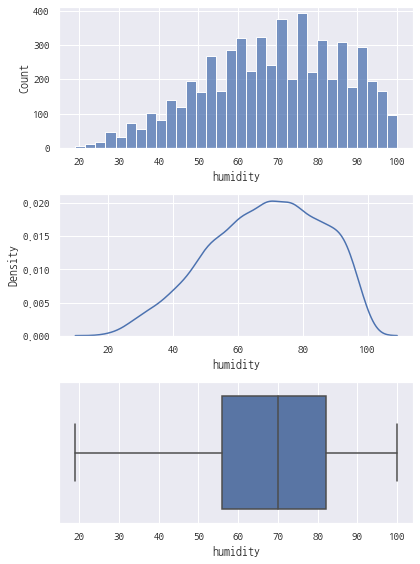

In [96]:
#변수의 분포를 시각화 라이브러리를 활용해 확인해보세요.
plt.figure(figsize = (6,8))
plt.subplot(3,1,1)
sns.histplot(data[feature], bins = 32)

plt.subplot(3,1,2)
sns.kdeplot(data[feature])

plt.subplot(3,1,3)
sns.boxplot(data[feature])

plt.tight_layout()
plt.show()

In [89]:
data[feature].value_counts().head(20)

70    142
76    138
75    128
63    127
77    127
69    125
66    124
71    118
78    116
68    116
72    116
60    113
81    110
85    109
79    106
73    106
67    106
61    105
62    104
86    104
Name: humidity, dtype: int64

6. 위 정보로 부터 파악한 내용 정리

In [ ]:
#위 정보로부터 파악하신 내용을 정리해보세요.
count    5827.000000
mean       68.608718
std        17.277266
min        19.000000
25%        56.000000
50%        70.000000
75%        82.000000
max       100.000000
Name: humidity, dtype: float64

평균값 68 중간값 70
min 19, max 100

7. 추가 분석사항 도출

In [ ]:
#추가로 분석을 원하는 부분이 있다면 분석후 정리해보세요.


### Feature6 : visibility

In [134]:
feature = 'visibility'

In [135]:
data[feature]

0       2000
1       2000
2       2000
3       2000
4       2000
        ... 
5822    1193
5823    1233
5824    1250
5825    1262
5826    1483
Name: visibility, Length: 5827, dtype: int64

1. 변수가 내포하고 있는 의미
- 변수의 의미를 한번 짚고 넘어갑시다. 여러분이 생각하는 이 변수의 의미를 작성해보세요.

In [ ]:
단위 : 0.1m
기상청에서 20이상은 따로 표시하지않는데 2000 값이 많은것을 보니 2000 = 20km 인것 같다.
    
땅 가까이에 위치한 적당한 크기의 검은 물체가 밝은 곳에 보이며 인식할 수 있는 최대 거리
1,000 칸델라 빛이 밝지 않은 곳에 보이고 식별할 수 있는 최대 거리

시정 장애
시정이 평소보다 떨어지는 것을 시정 장애라고 부른다. 이러한 장애는 보통 안개, 놀, 아지랑이뿐 아니라 눈, 비 등의 날씨 속에서 자주 일어난다.
안개의 국제적 정의는 1 킬로미터보다 낮은 시정이다. 놀의 경우 1~2 킬로미터 사이이다. 또, 아지랑이의 경우 2~5 킬로미터 사이이다.
안개 1km
놀 1~2km
아지랑이 2~5

2. 변수가 수치형인지 범주형인지


In [136]:
#변수의 자료형을 확인해보세요.
수치형 데이터

SyntaxError: invalid syntax (Temp/ipykernel_4408/3191878136.py, line 2)

3. 변수의 결측치 존재 여부 및 조치방안

In [137]:
#변수의 결측치 존재 여부를 확인하고, 만약 결측치가 존재하면 어떻게 처리할지 고민해보세요. 
data[feature].isna().sum()

0

In [ ]:
x 결측치는 존재하지않는다.

4. 변수의 기초 통계량 확인

In [141]:
#변수의 기초 통계량을 확인해보세요
data[feature].describe()

count    5827.000000
mean     1758.438648
std       490.969394
min        60.000000
25%      1935.500000
50%      2000.000000
75%      2000.000000
max      2000.000000
Name: visibility, dtype: float64

5. 변수의 분포 확인

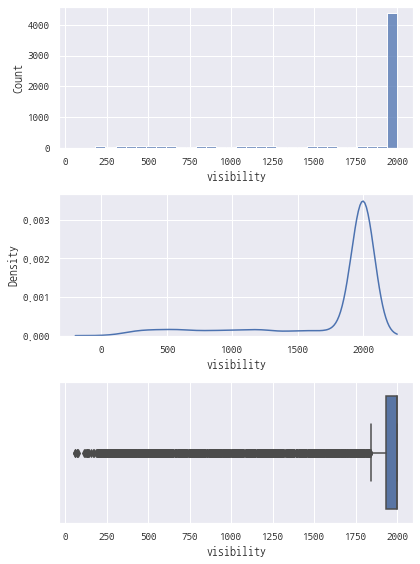

In [142]:
#변수의 분포를 시각화 라이브러리를 활용해 확인해보세요.
plt.figure(figsize = (6,8))
plt.subplot(3,1,1)
sns.histplot(data[feature], bins = 32)

plt.subplot(3,1,2)
sns.kdeplot(data[feature])

plt.subplot(3,1,3)
sns.boxplot(data[feature])

plt.tight_layout()
plt.show()

In [89]:
data[feature].value_counts().head(20)

70    142
76    138
75    128
63    127
77    127
69    125
66    124
71    118
78    116
68    116
72    116
60    113
81    110
85    109
79    106
73    106
67    106
61    105
62    104
86    104
Name: humidity, dtype: int64

6. 위 정보로 부터 파악한 내용 정리

In [ ]:
#위 정보로부터 파악하신 내용을 정리해보세요.
count    5827.000000
mean     1758.438648
std       490.969394
min        60.000000
25%      1935.500000
50%      2000.000000
75%      2000.000000
max      2000.000000
Name: visibility, dtype: float64

평균값 1758 중간값 2000
min 60, max 2000

대다수의 날이 20km 이상이므로, 가시성이 좋지않은 날은 진짜 따릉이 타기는 힘들것 같다.

7. 추가 분석사항 도출

In [145]:
#추가로 분석을 원하는 부분이 있다면 분석후 정리해보세요.
#단위를 km로 바꿈
data[feature] = data[feature]/100
data[feature]

0       20.00
1       20.00
2       20.00
3       20.00
4       20.00
        ...  
5822    11.93
5823    12.33
5824    12.50
5825    12.62
5826    14.83
Name: visibility, Length: 5827, dtype: float64

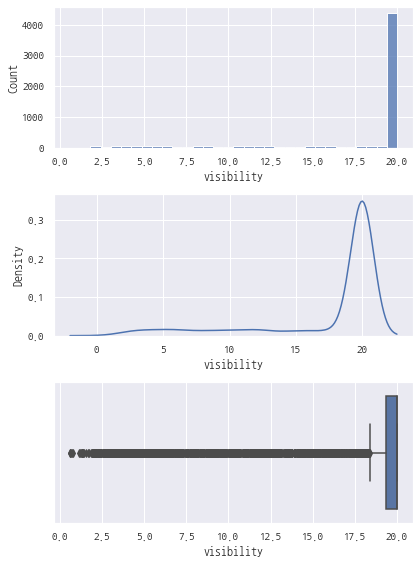

In [146]:
#변수의 분포를 시각화 라이브러리를 활용해 확인해보세요.
plt.figure(figsize = (6,8))
plt.subplot(3,1,1)
sns.histplot(data[feature], bins = 32)

plt.subplot(3,1,2)
sns.kdeplot(data[feature])

plt.subplot(3,1,3)
sns.boxplot(data[feature])

plt.tight_layout()
plt.show()

### Feature7 : ozone

In [147]:
feature = 'ozone'

In [148]:
data[feature]

0       0.002
1       0.003
2       0.023
3       0.028
4       0.008
        ...  
5822    0.002
5823    0.002
5824    0.002
5825    0.001
5826    0.004
Name: ozone, Length: 5827, dtype: float64

1. 변수가 내포하고 있는 의미
- 변수의 의미를 한번 짚고 넘어갑시다. 여러분이 생각하는 이 변수의 의미를 작성해보세요.

In [ ]:
단위 : DU
오존의 농도는 돕슨(DU: Dobson Unit)
1DU는 지표상의 대기 1기압에서 약 0.01㎜의 오존 두께에 해당한다.
오존의 평균적인 농도는 약 350~400DU 정도인데 이에 못 미친 200DU 이하가 되었을 때를 오존 구멍 또는 오존홀이라 한다.

2. 변수가 수치형인지 범주형인지


In [80]:
#변수의 자료형을 확인해보세요.
수치형 데이터

3. 변수의 결측치 존재 여부 및 조치방안

In [149]:
#변수의 결측치 존재 여부를 확인하고, 만약 결측치가 존재하면 어떻게 처리할지 고민해보세요. 
data[feature].isna().sum()

128

In [ ]:
o, 결측치 존재 평균값으로 바꿈

In [150]:
data[feature] = data[feature].interpolate(method='linear')
data[feature].isna().sum()

0

4. 변수의 기초 통계량 확인

In [151]:
#변수의 기초 통계량을 확인해보세요
data[feature].describe()

count    5827.000000
mean        0.031634
std         0.018263
min         0.001000
25%         0.019000
50%         0.030000
75%         0.041000
max         0.137000
Name: ozone, dtype: float64

In [ ]:
우리나라 연평균 DU가 320~340 이므로 단위가 맞지 않는것 같아 바꿔준다.

In [153]:
data[feature] = data[feature] * 10000
data[feature]

0        20.0
1        30.0
2       230.0
3       280.0
4        80.0
        ...  
5822     20.0
5823     20.0
5824     20.0
5825     10.0
5826     40.0
Name: ozone, Length: 5827, dtype: float64

In [157]:
print(list(data[feature]))

[20.0, 30.0, 230.0, 280.0, 80.0, 90.0, 180.0, 270.0, 320.0, 330.0, 380.0, 420.0, 440.0, 440.0, 450.0, 450.0, 429.99999999999994, 390.0, 370.0, 360.0, 340.0, 370.0, 380.0, 390.0, 400.0, 400.0, 390.0, 390.0, 370.0, 340.0, 320.0, 320.0, 350.00000000000006, 360.0, 370.0, 390.0, 410.0, 420.0, 420.0, 360.0, 250.0, 100.0, 80.0, 150.0, 90.0, 20.0, 20.0, 60.0, 220.0, 190.0, 230.0, 300.0, 260.0, 270.0, 260.0, 220.0, 260.0, 260.0, 180.0, 210.0, 210.0, 170.0, 150.0, 150.0, 170.0, 150.0, 190.0, 220.0, 280.0, 310.0, 360.0, 370.0, 380.0, 380.0, 370.0, 370.0, 350.00000000000006, 340.0, 310.0, 300.0, 320.0, 320.0, 330.0, 360.0, 360.0, 350.00000000000006, 330.0, 320.0, 340.0, 340.0, 290.0, 260.0, 260.0, 250.0, 240.0, 220.0, 200.0, 220.0, 240.0, 250.0, 220.0, 160.0, 150.0, 200.0, 290.0, 300.0, 330.0, 350.00000000000006, 350.00000000000006, 370.0, 380.0, 380.0, 370.0, 340.0, 230.0, 190.0, 170.0, 180.0, 170.0, 260.0, 250.0, 210.0, 230.0, 160.0, 80.0, 80.0, 40.0, 80.0, 100.0, 260.0, 380.0, 490.0, 530.0, 550

In [154]:
data[feature].describe()

count    5827.000000
mean      316.336022
std       182.630207
min        10.000000
25%       190.000000
50%       300.000000
75%       410.000000
max      1370.000000
Name: ozone, dtype: float64

5. 변수의 분포 확인

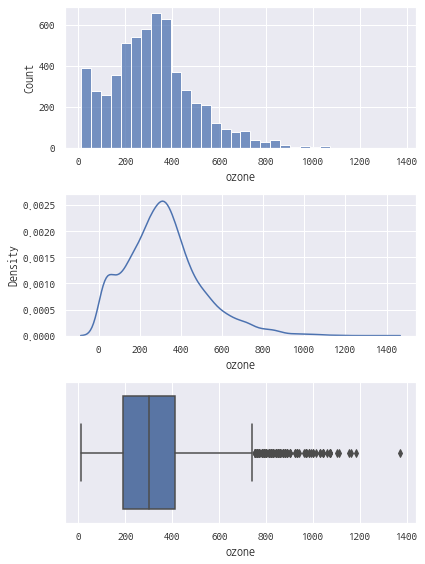

In [155]:
#변수의 분포를 시각화 라이브러리를 활용해 확인해보세요.
plt.figure(figsize = (6,8))
plt.subplot(3,1,1)
sns.histplot(data[feature], bins = 32)

plt.subplot(3,1,2)
sns.kdeplot(data[feature])

plt.subplot(3,1,3)
sns.boxplot(data[feature])

plt.tight_layout()
plt.show()

In [89]:
data[feature].value_counts().head(20)

70    142
76    138
75    128
63    127
77    127
69    125
66    124
71    118
78    116
68    116
72    116
60    113
81    110
85    109
79    106
73    106
67    106
61    105
62    104
86    104
Name: humidity, dtype: int64

6. 위 정보로 부터 파악한 내용 정리

In [ ]:
#위 정보로부터 파악하신 내용을 정리해보세요.
count    5827.000000
mean      316.336022
std       182.630207
min        10.000000
25%       190.000000
50%       300.000000
75%       410.000000
max      1370.000000
Name: ozone, dtype: float64
        
평균 316, median 300
min 182, max 1370

7. 추가 분석사항 도출

In [ ]:
#추가로 분석을 원하는 부분이 있다면 분석후 정리해보세요.


### Feature9 : PM2.5

In [203]:
feature = 'PM10'

1. 변수가 내포하고 있는 의미
- 변수의 의미를 한번 짚고 넘어갑시다. 여러분이 생각하는 이 변수의 의미를 작성해보세요.

초미세먼지 수치(머리카락 굵기의 1/20에서 1/30 크기의 미세먼지)
좋음 : 0~15
보통 : 16~35
나쁨 : 36~75
매우나쁨 : 76~
세계보건기구 기준에 따르면 초미세먼지 수치가 25μg/m³이하여야 보통의 환경이다. 
                                             50μg/m³이상이면 매우 나쁜 환경이다.

2. 변수가 수치형인지 범주형인지


In [ ]:
#변수의 자료형을 확인해보세요.
수치형이다.

3. 변수의 결측치 존재 여부 및 조치방안

In [100]:
#변수의 결측치 존재 여부를 확인하고, 만약 결측치가 존재하면 어떻게 처리할지 고민해보세요. 
data[target].isna().sum()

0

In [206]:
o, 결측치가 존재하므로 이전,이후의 평균값으로 설정

SyntaxError: invalid syntax (Temp/ipykernel_4408/50261873.py, line 1)

In [207]:
data[feature] = data[feature].interpolate(method='linear')
data[feature].isna().sum()

0

4. 변수의 기초 통계량 확인

In [102]:
#변수의 기초 통계량을 확인해보세요
data[target].describe()

count    5827.000000
mean      215.117899
std       185.972900
min         1.000000
25%        53.000000
50%       186.000000
75%       315.000000
max      1746.000000
Name: count, dtype: float64

5. 변수의 분포 확인

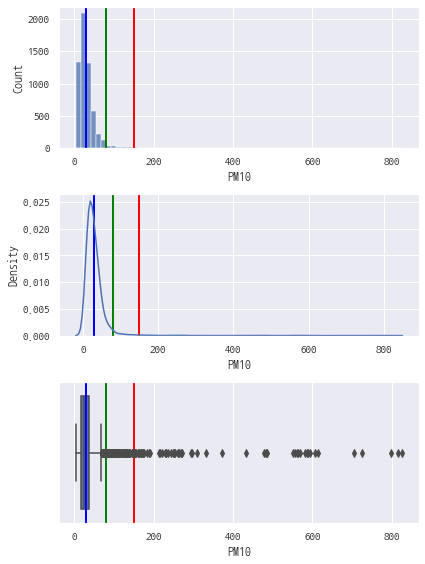

In [69]:
#변수의 분포를 시각화 라이브러리를 활용해 확인해보세요.
plt.figure(figsize = (6,8))
plt.subplot(3,1,1)
plt.axvline(30, 0, 500, color='blue', linestyle='-', linewidth=2)
plt.axvline(80, 0, 500, color='green', linestyle='-', linewidth=2)
plt.axvline(150, 0, 500, color='red', linestyle='-', linewidth=2)
sns.histplot(data[feature], bins = 64)

plt.subplot(3,1,2)
plt.axvline(30, 0, 500, color='blue', linestyle='-', linewidth=2)
plt.axvline(80, 0, 500, color='green', linestyle='-', linewidth=2)
plt.axvline(150, 0, 500, color='red', linestyle='-', linewidth=2)
sns.kdeplot(data[feature])

plt.subplot(3,1,3)
plt.axvline(30, 0, 500, color='blue', linestyle='-', linewidth=2)
plt.axvline(80, 0, 500, color='green', linestyle='-', linewidth=2)
plt.axvline(150, 0, 500, color='red', linestyle='-', linewidth=2)
sns.boxplot(data[feature])

plt.tight_layout()
plt.show()

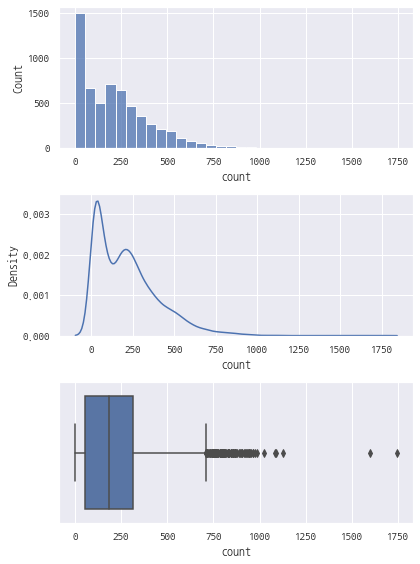

In [107]:
#변수의 분포를 시각화 라이브러리를 활용해 확인해보세요.
plt.figure(figsize = (6,8))
plt.subplot(3,1,1)
sns.histplot(data[target], bins = 32)

plt.subplot(3,1,2)
sns.kdeplot(data[target])

plt.subplot(3,1,3)
sns.boxplot(data[target])

plt.tight_layout()
plt.show()

6. 위 정보로 부터 파악한 내용 정리

In [ ]:
#위 정보로부터 파악하신 내용을 정리해보세요.
두가지 그룹으로 나눠지는것 같은데 0인 부분이랑 100이상인 부분으로 나눠지는것같다.

0인부분은 아마 밤이지 않을까 싶다.
밤에는 따릉이를 타기 어려우니깐 데이터적으로 빼는것도 고려해볼만하다.

In [70]:
data[feature].sort_values()

75        3.0
2253      3.0
812       3.0
4266      3.0
2251      3.0
        ...  
882     706.0
886     726.0
883     799.0
884     817.0
885     827.0
Name: PM10, Length: 5827, dtype: float64

7. 추가 분석사항 도출

In [ ]:
#추가로 분석을 원하는 부분이 있다면 분석후 정리해보세요.
낮과 밤데이터 구분 분석

### Feature9 : PM2.5

In [55]:
feature = 'PM2.5'

1. 변수가 내포하고 있는 의미
- 변수의 의미를 한번 짚고 넘어갑시다. 여러분이 생각하는 이 변수의 의미를 작성해보세요.

초미세먼지 수치(머리카락 굵기의 1/20에서 1/30 크기의 미세먼지)
좋음 : 0~15
보통 : 16~35
나쁨 : 36~75
매우나쁨 : 76~
세계보건기구 기준에 따르면 초미세먼지 수치가 25μg/m³이하여야 보통의 환경이다. 
                                             50μg/m³이상이면 매우 나쁜 환경이다.

2. 변수가 수치형인지 범주형인지


In [ ]:
#변수의 자료형을 확인해보세요.
수치형이다.

3. 변수의 결측치 존재 여부 및 조치방안

In [100]:
#변수의 결측치 존재 여부를 확인하고, 만약 결측치가 존재하면 어떻게 처리할지 고민해보세요. 
data[target].isna().sum()

0

In [218]:
data[feature] = data[feature].interpolate(method='linear')
data[feature].isna().sum()

0

In [52]:
na 값이 95인데
앞뒤 값이 평균으로 채우면 비슷하게 맞을것 같다.

SyntaxError: invalid syntax (Temp/ipykernel_4408/1604165411.py, line 1)

4. 변수의 기초 통계량 확인

In [102]:
#변수의 기초 통계량을 확인해보세요
data[target].describe()

count    5827.000000
mean      215.117899
std       185.972900
min         1.000000
25%        53.000000
50%       186.000000
75%       315.000000
max      1746.000000
Name: count, dtype: float64

5. 변수의 분포 확인

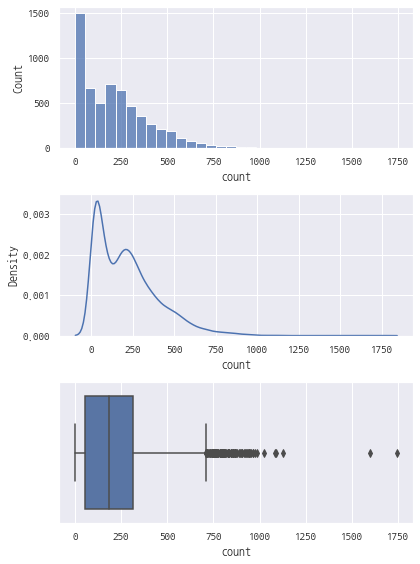

In [107]:
#변수의 분포를 시각화 라이브러리를 활용해 확인해보세요.
plt.figure(figsize = (6,8))
plt.subplot(3,1,1)
sns.histplot(data[target], bins = 32)

plt.subplot(3,1,2)
sns.kdeplot(data[target])

plt.subplot(3,1,3)
sns.boxplot(data[target])

plt.tight_layout()
plt.show()

6. 위 정보로 부터 파악한 내용 정리

In [ ]:
#위 정보로부터 파악하신 내용을 정리해보세요.
count    5827.000000
mean       15.633774
std        13.791083
min         1.000000
25%         7.000000
50%        13.000000
75%        20.000000
max       125.000000
Name: PM2.5, dtype: float64
평균은 15.6이고 min은 1 max는 125값을 가진다.
3사분위 값이 20인걸 보니 대부분의 날이 초미세먼지는 보통d이하이다.

안좋은 날들도 있으니 분석해보자

7. 추가 분석사항 도출

In [ ]:
#추가로 분석을 원하는 부분이 있다면 분석후 정리해보세요.
낮과 밤데이터 구분 분석

### Count (Target)

In [99]:
data.head()

,date,hour,PM10,PM2.5,ozone,temperature,precipitation,windspeed,humidity,visibility,count
0,2021-04-01,1,42.0,21.0,0.002,13.1,0,1.4,49,2000,46
1,2021-04-01,2,41.0,21.0,0.003,12.4,0,2.1,53,2000,40
2,2021-04-01,3,30.0,13.0,0.023,13.1,0,3.4,43,2000,31
3,2021-04-01,4,27.0,12.0,0.028,13.0,0,3.1,44,2000,12
4,2021-04-01,5,29.0,14.0,0.008,13.0,0,2.9,44,2000,30


In [98]:
target = 'count'

1. 변수가 내포하고 있는 의미
- 변수의 의미를 한번 짚고 넘어갑시다. 여러분이 생각하는 이 변수의 의미를 작성해보세요.

In [ ]:
따릉이 이용량

2. 변수가 수치형인지 범주형인지


In [ ]:
#변수의 자료형을 확인해보세요.
수치형이다.

3. 변수의 결측치 존재 여부 및 조치방안

In [100]:
#변수의 결측치 존재 여부를 확인하고, 만약 결측치가 존재하면 어떻게 처리할지 고민해보세요. 
data[target].isna().sum()

0

In [ ]:
x, 결측치가 없다.

4. 변수의 기초 통계량 확인

In [102]:
#변수의 기초 통계량을 확인해보세요
data[target].describe()

count    5827.000000
mean      215.117899
std       185.972900
min         1.000000
25%        53.000000
50%       186.000000
75%       315.000000
max      1746.000000
Name: count, dtype: float64

5. 변수의 분포 확인

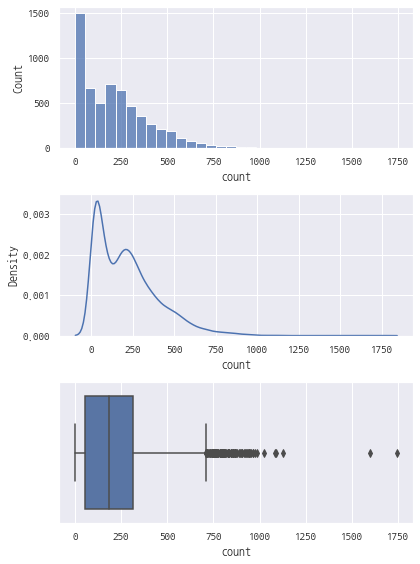

In [107]:
#변수의 분포를 시각화 라이브러리를 활용해 확인해보세요.
plt.figure(figsize = (6,8))
plt.subplot(3,1,1)
sns.histplot(data[target], bins = 32)

plt.subplot(3,1,2)
sns.kdeplot(data[target])

plt.subplot(3,1,3)
sns.boxplot(data[target])

plt.tight_layout()
plt.show()

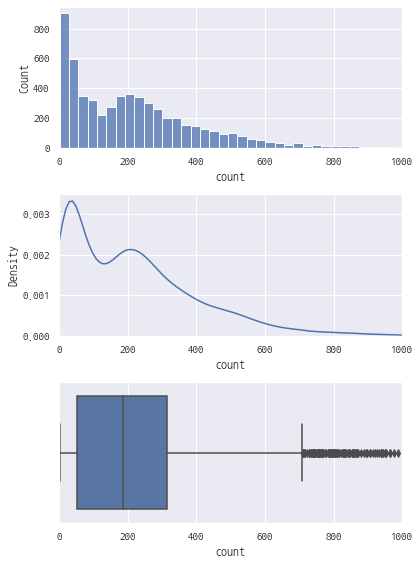

In [109]:
#변수의 분포를 시각화 라이브러리를 활용해 확인해보세요.
plt.figure(figsize = (6,8))
plt.subplot(3,1,1)
plt.xlim(0,1000)
sns.histplot(data[target], bins = 64)

plt.subplot(3,1,2)
plt.xlim(0,1000)
sns.kdeplot(data[target])

plt.subplot(3,1,3)
plt.xlim(0,1000)
sns.boxplot(data[target])

plt.tight_layout()
plt.show()

6. 위 정보로 부터 파악한 내용 정리

In [ ]:
#위 정보로부터 파악하신 내용을 정리해보세요.
두가지 그룹으로 나눠지는것 같은데 0인 부분이랑 100이상인 부분으로 나눠지는것같다.

0인부분은 아마 밤이지 않을까 싶다.
밤에는 따릉이를 타기 어려우니깐 데이터적으로 빼는것도 고려해볼만하다.

7. 추가 분석사항 도출

In [ ]:
#추가로 분석을 원하는 부분이 있다면 분석후 정리해보세요.
낮과 밤데이터 구분 분석

### 4.이변량 분석 
* 자료의 종류에 맞게 X --> Y 에 대해서 그래프(시각화)와 가설검정(수치화)를 수행하고 결과를 평가합니다.
* 가설검정시 다음의 항목을 참조하여 수행합니다.
    * 적절한 유의수준
    * 숫자 --> 숫자 : 상관분석
    * 범주 --> 범주 : 카이제곱검정
    * 범주 --> 숫자 : t검정, 분산분석
    * 숫자 --> 범주 : 로지스틱 회귀모형을 통해, 회귀계수의 P.value로 검정을 수행합니다.

#### (1) 범주형 Feature --> 숫자형 Y (따릉이 대여 Count)

<font color="green">* 모든 범주형 Feature에 대해서 Y와 비교하여 차트를 그리고 수치화 하시오.</font>


        1. 시각화 : 그래프를 활용한 데이터 분석
        2. 수치화 : t-test, anova
        3. 관계 평가 (가설 검정)

1. 강수 여부와 따릉이 대여량간 이변량 분석

In [9]:
#데이터 타입에 주의하여 이변량 분석을 해보세요

In [158]:
feature = 'precipitation'

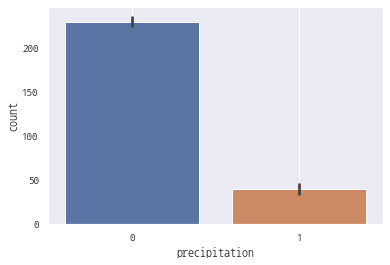

In [159]:
sns.barplot(x=feature, y=target, data=data)
plt.grid()
plt.show()

In [160]:
sunny = data.loc[data[feature] == 0, target]
rain = data.loc[data[feature] == 1, target]

In [162]:
spst.ttest_ind(sunny, rain)

Ttest_indResult(statistic=21.389614151911022, pvalue=8.86239184041254e-98)

In [ ]:
2보다 크기 때문에 차이가 있다는 대립가설 성립
p-value도 0.05 보다 작아 유의하다.

#### (2) 숫자형 Feature --> 숫자형 Y (따릉이 대여 Count)

<font color="green">* 모든 숫자형 Feature에 대해서 Y와 비교하여 차트를 그리고 수치화 하시오.  </font>


        1. 시각화 : 그래프를 활용한 데이터 분석
        2. 수치화 : 상관분석
        3. 관계 평가 (가설 검정)

In [167]:
data.corr()

,hour,PM10,PM2.5,ozone,temperature,precipitation,windspeed,humidity,visibility,count
hour,1.000000,0.044216,0.049832,0.224982,0.190606,-0.000085,0.220301,-0.304287,0.088881,0.586435
PM10,0.044216,1.000000,0.684193,-0.003014,-0.127034,-0.095161,0.043421,-0.088692,-0.289495,0.028282
PM2.5,0.049832,0.684193,1.000000,0.017959,-0.110659,-0.133784,-0.136576,-0.035074,-0.433992,0.037130
ozone,0.224982,-0.003014,0.017959,1.000000,0.536935,-0.080957,0.340405,-0.407100,0.153040,0.317992
temperature,0.190606,-0.127034,-0.110659,0.536935,1.000000,-0.040205,0.051311,-0.092162,0.143919,0.277169
precipitation,-0.000085,-0.095161,-0.133784,-0.080957,-0.040205,1.000000,0.045742,0.384594,-0.494057,-0.269859
windspeed,0.220301,0.043421,-0.136576,0.340405,0.051311,0.045742,1.000000,-0.292127,0.084418,0.223722
humidity,-0.304287,-0.088692,-0.035074,-0.407100,-0.092162,0.384594,-0.292127,1.000000,-0.487472,-0.478955
visibility,0.088881,-0.289495,-0.433992,0.153040,0.143919,-0.494057,0.084418,-0.487472,1.000000,0.265828
count,0.586435,0.028282,0.037130,0.317992,0.277169,-0.269859,0.223722,-0.478955,0.265828,1.000000


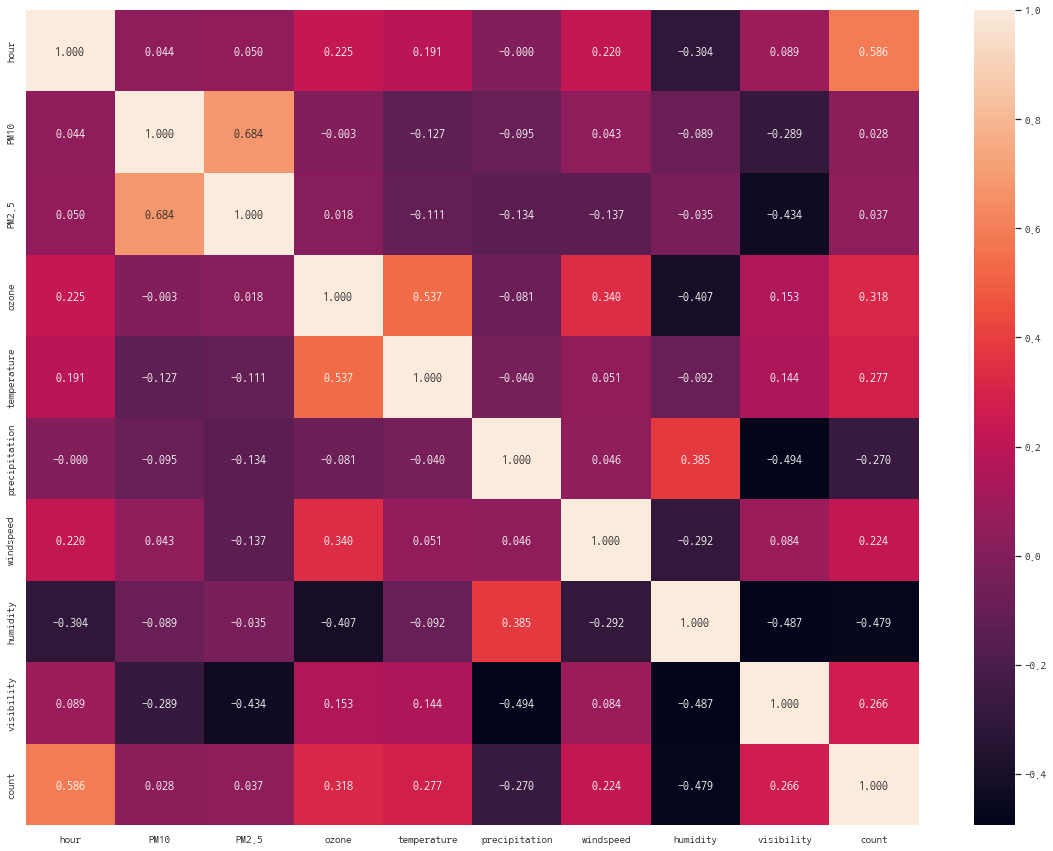

In [173]:
plt.figure(figsize=(20, 15))
sns.heatmap(data.corr(), annot = True, fmt = '.3f')
plt.show()

2. 시간대별 데이터와 따릉이 대여량간 분석

In [10]:
#데이터 타입에 주의하여 이변량 분석을 해보세요

In [163]:
feature = 'hour'

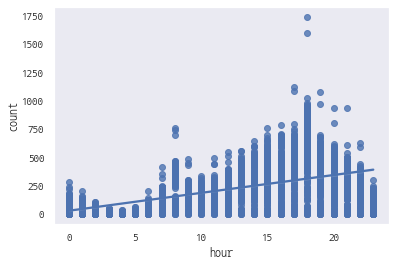

In [164]:
sns.regplot(x=feature, y=target, data=data)
plt.grid()
plt.show()

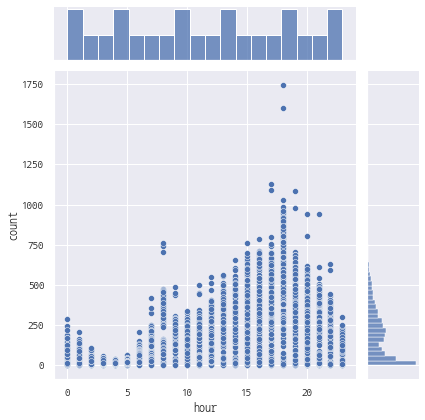

In [165]:
sns.jointplot(x=feature, y=target, data = data)
plt.show()

In [166]:
spst.pearsonr(data[feature], data[target])

(0.5864350283919393, 0.0)

3. 온도 데이터와 따릉이 대여량간 분석

In [11]:
#데이터 타입에 주의하여 이변량 분석을 해보세요

In [174]:
feature = 'temperature'

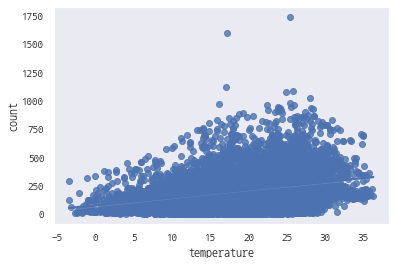

In [175]:
sns.regplot(x=feature, y=target, data=data)
plt.grid()
plt.show()

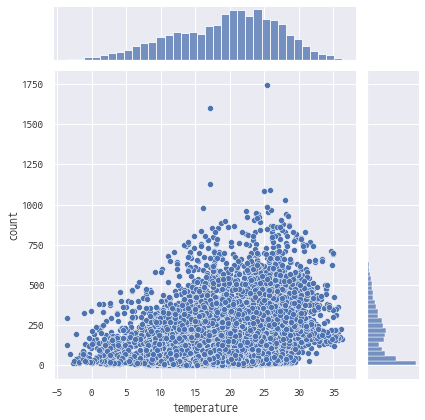

In [176]:
sns.jointplot(x=feature, y=target, data = data)
plt.show()

In [177]:
spst.pearsonr(data[feature], data[target])

(0.2771692363089791, 2.9405165551619465e-103)

4. 풍속 데이터와 따릉이 대여량간 분석

In [179]:
#데이터 타입에 주의하여 이변량 분석을 해보세요

In [180]:
feature = 'windspeed'

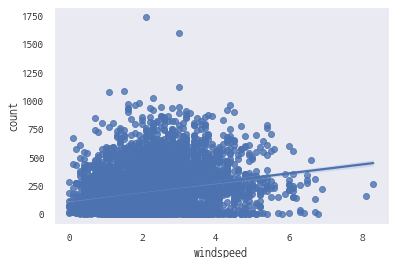

In [181]:
sns.regplot(x=feature, y=target, data=data)
plt.grid()
plt.show()

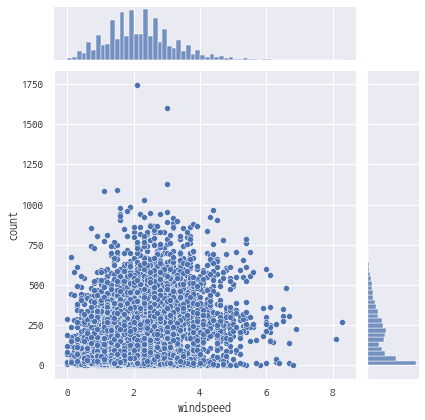

In [182]:
sns.jointplot(x=feature, y=target, data = data)
plt.show()

In [183]:
spst.pearsonr(data[feature], data[target])

(0.22372189900674888, 5.2433176782994606e-67)

5. 습도 데이터와 따릉이 대여량간 분석

In [13]:
#데이터 타입에 주의하여 이변량 분석을 해보세요

In [184]:
feature = 'humidity'

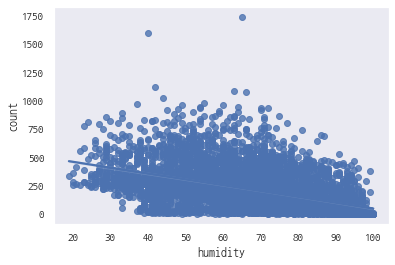

In [185]:
sns.regplot(x=feature, y=target, data=data)
plt.grid()
plt.show()

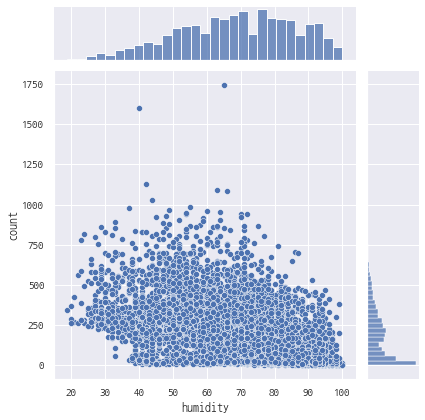

In [186]:
sns.jointplot(x=feature, y=target, data = data)
plt.show()

In [187]:
spst.pearsonr(data[feature], data[target])

(-0.4789554265904137, 0.0)

6. 시정 데이터와 따릉이 대여량간 분석

In [14]:
#데이터 타입에 주의하여 이변량 분석을 해보세요

In [188]:
feature = 'visibility'

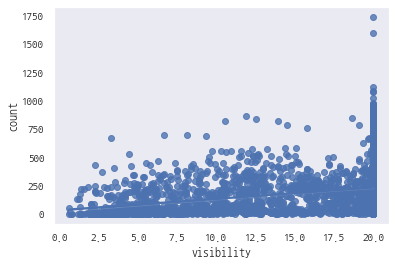

In [189]:
sns.regplot(x=feature, y=target, data=data)
plt.grid()
plt.show()

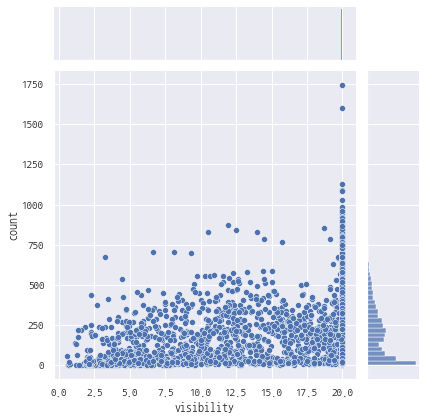

In [190]:
sns.jointplot(x=feature, y=target, data = data)
plt.show()

In [191]:
spst.pearsonr(data[feature], data[target])

(0.26582778327488765, 7.876003852900128e-95)

7. 오존 데이터와 따릉이 대여량간 분석

In [15]:
#데이터 타입에 주의하여 이변량 분석을 해보세요

In [192]:
feature = 'ozone'

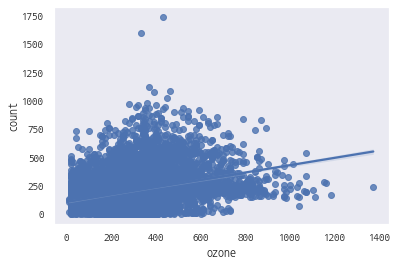

In [193]:
sns.regplot(x=feature, y=target, data=data)
plt.grid()
plt.show()

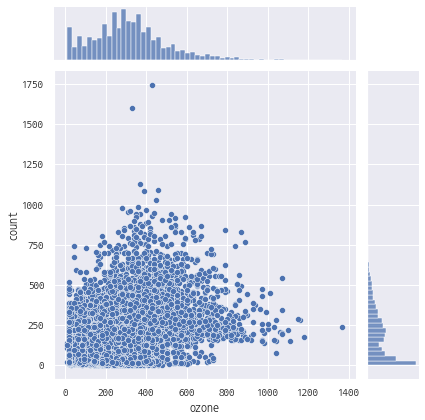

In [194]:
sns.jointplot(x=feature, y=target, data = data)
plt.show()

In [195]:
spst.pearsonr(data[feature], data[target])

(0.31799186556914855, 4.721727543204258e-137)

8. 미세먼지 농도 데이터와 따릉이 대여량간 분석

In [16]:
#데이터 타입에 주의하여 이변량 분석을 해보세요

In [208]:
feature = 'PM10'

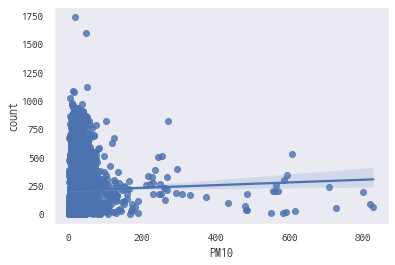

In [209]:
sns.regplot(x=feature, y=target, data=data)
plt.grid()
plt.show()

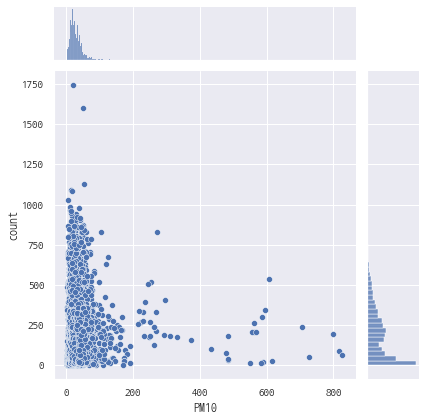

In [210]:
sns.jointplot(x=feature, y=target, data = data)
plt.show()

In [211]:
data[feature].isna().sum()

0

In [212]:
spst.pearsonr(data[feature], data[target])

(0.02753552779908241, 0.03556499262323277)

9. 초미세먼지 농도 데이터와 따릉이 대여량간 분석

In [17]:
#데이터 타입에 주의하여 이변량 분석을 해보세요

In [213]:
feature = 'PM2.5'

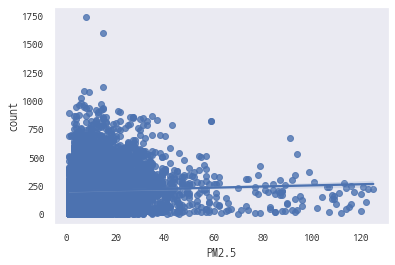

In [214]:
sns.regplot(x=feature, y=target, data=data)
plt.grid()
plt.show()

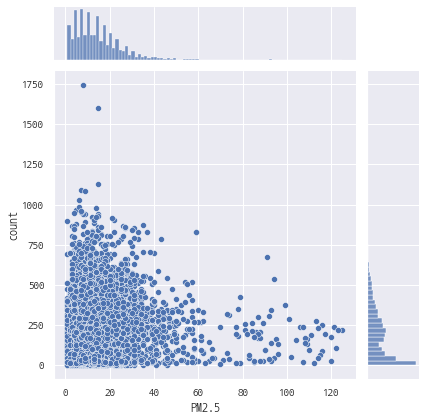

In [215]:
sns.jointplot(x=feature, y=target, data = data)
plt.show()

In [219]:
spst.pearsonr(data[feature], data[target])

(0.034833977797175945, 0.007830765224579699)

### 5. 가설 검정

#### <font color='green'>1. 강한 관계의 변수 (대립가설 채택)</font>

In [ ]:
강수 여부, 시간, 습도

#### <font color='green'>2. 약한 관계의 변수</font>


In [ ]:
양 온도, 풍속, 시정, 오존

#### <font color='green'>3. 관계 없는 변수 (귀무가설 채택)</font>


In [220]:
PM10, PM2.5

SyntaxError: invalid syntax (Temp/ipykernel_4408/2934871455.py, line 1)

### 6. Insight 도출

In [ ]:
강수 여부, 시간, 습도와 강한 양의 상관관계를 갖는다.

In [221]:
data['1hour_ago_precipitation'] = data['precipitation'].shift()
data

,date,hour,PM10,PM2.5,ozone,temperature,precipitation,windspeed,humidity,visibility,count,1hour_ago_precipitation
0,2021-04-01,1,42.0,21.0,20.0,13.1,0,1.4,49,20.00,46,NaN
1,2021-04-01,2,41.0,21.0,30.0,12.4,0,2.1,53,20.00,40,0.0
2,2021-04-01,3,30.0,13.0,230.0,13.1,0,3.4,43,20.00,31,0.0
3,2021-04-01,4,27.0,12.0,280.0,13.0,0,3.1,44,20.00,12,0.0
4,2021-04-01,5,29.0,14.0,80.0,13.0,0,2.9,44,20.00,30,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
5822,2021-11-29,20,74.0,58.0,20.0,9.3,0,0.3,66,11.93,273,0.0
5823,2021-11-29,21,65.0,56.0,20.0,8.4,0,2.0,70,12.33,228,0.0
5824,2021-11-29,22,51.0,41.0,20.0,8.6,0,1.9,70,12.50,215,0.0
5825,2021-11-29,23,43.0,35.0,10.0,8.2,0,2.1,71,12.62,125,0.0


In [222]:
feature = '1hour_ago_precipitation'

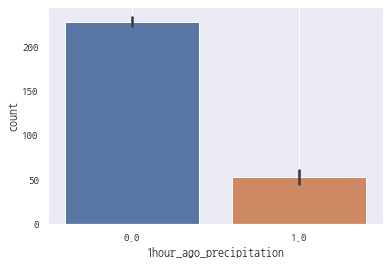

In [226]:
sns.barplot(x=feature, y=target, data=data)
plt.grid()
plt.show()

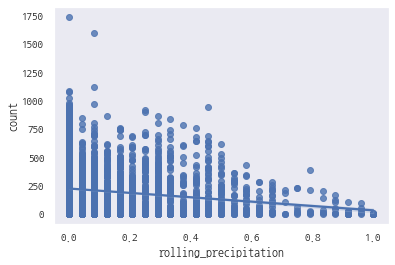

In [251]:
sns.regplot(x=feature, y=target, data=data)
plt.grid()
plt.show()

In [252]:
spst.pearsonr(data[feature], data[target])

(-0.16283776252313611, 6.491248166212263e-36)

In [249]:
data['rolling_precipitation'] = data['precipitation'].rolling(window=24, min_periods=1).mean()
data.head()

,date,hour,PM10,PM2.5,ozone,temperature,precipitation,windspeed,humidity,visibility,count,1hour_ago_precipitation,rolling_precipitation
0,2021-04-01,1,42.0,21.0,20.0,13.1,0,1.4,49,20.0,46,NaN,0.0
1,2021-04-01,2,41.0,21.0,30.0,12.4,0,2.1,53,20.0,40,0.0,0.0
2,2021-04-01,3,30.0,13.0,230.0,13.1,0,3.4,43,20.0,31,0.0,0.0
3,2021-04-01,4,27.0,12.0,280.0,13.0,0,3.1,44,20.0,12,0.0,0.0
4,2021-04-01,5,29.0,14.0,80.0,13.0,0,2.9,44,20.0,30,0.0,0.0


In [250]:
feature = 'rolling_precipitation'

In [ ]:
sns.barplot(x=feature, y=target, data=data)
plt.grid()
plt.show()

In [ ]:
spst.pearsonr(data[feature], data[target])


In [ ]:
현재 강우 여부 = Ttest_indResult(statistic=21.389614151911022, pvalue=8.86239184041254e-98)
1시간 이전 강우 여부 = Ttest_indResult(statistic=19.629250121432506, pvalue=4.024681326925144e-83)
값이 작아졌으므로 현재 강우 여부가 더 중요한것으로 보여진다.

In [245]:
temp_data = data.loc[data['count'] == 1,]
temp_data = data.loc[data['visibility'] < 0.1,]

In [246]:
display(temp_data)

,date,hour,PM10,PM2.5,ozone,temperature,precipitation,windspeed,humidity,visibility,count,1hour_ago_precipitation


In [234]:
pd.set_option('display.max_rows', None)